variables: k, epsilon, n_iter, privacy budget

- epsilon = 0.5,1,2,5
- k depends on dataset, can try around 10 values close to true number of groups. 
- n_iter = 3,4,5,6,7,8 maybe? 

Privacy Budget Choices
- Uniform
- Dichotomy
- Series Sum

Most basic analysis required: for epsilon=1 vary the number of centers, number of iterations and try different privacy budget allocation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lloyd import PrivacyBudget, dplloyd
from evaluation_utils import kmeans_loss

master_rng = np.random.default_rng(42)

### Initial Experimentation: How many iterations is preferable? 

(3, 3, 2)


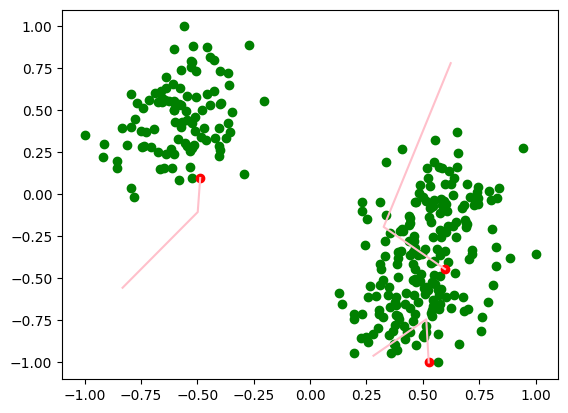

Loss:  0.1462954199633054


In [7]:
from sklearn.cluster import KMeans

data = np.load("datasets/synthetic-gaussian.npy")
p = PrivacyBudget(epsilon=1, method="uniform", total_iter=2)
centers = np.array(dplloyd(k=3, X=data, n_iter=2, priv=p, seed=123, return_steps=True))

print(centers.shape)
#non_private_centers = KMeans(n_clusters=3).fit(data).cluster_centers_

fig = plt.figure()
ax = plt.axes()
ax.scatter(data[:,0], data[:,1], c='green')
#ax.scatter(non_private_centers[:,0], non_private_centers[:,1], c='red')
ax.plot(centers[:,:,0], centers[:,:,1], c="pink")
ax.scatter(centers[-1,:,0], centers[-1,:,1], c="red")

plt.show()

print("Loss: ", kmeans_loss(centers[-1,:,:], data))

Center 0, Iteration 0, points assigned 17, n [43.17109723], s[ 53.73089868 -85.87670344]
Center 1, Iteration 0, points assigned 2629, n [2655.17109723], s[856.72700817 499.38355838]
Center 2, Iteration 0, points assigned 1950, n [1976.17109723], s[-927.59753169  149.08411864]
Center 3, Iteration 0, points assigned 605, n [631.17109723], s[ 348.93883375 -215.96113139]
Center 4, Iteration 0, points assigned 9, n [35.17109723], s[ 52.26051369 -81.7770958 ]
Center 0, Iteration 1, points assigned 4, n [30.17109723], s[ 55.46889579 -85.12548233]
Center 1, Iteration 1, points assigned 2610, n [2636.17109723], s[788.68267507 467.10297003]
Center 2, Iteration 1, points assigned 1993, n [2019.17109723], s[-942.17937633  170.99929383]
Center 3, Iteration 1, points assigned 603, n [629.17109723], s[ 429.74533361 -206.76284746]
Center 0, Iteration 2, points assigned 4, n [30.17109723], s[ 55.46889579 -85.12548233]
Center 1, Iteration 2, points assigned 2006, n [2032.17109723], s[758.05282981 386.69

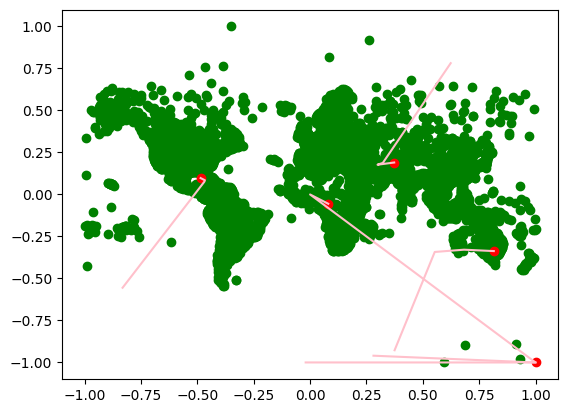

Loss:  0.07367006321041424


In [10]:
data = np.load("datasets/airports.npy")

p = PrivacyBudget(epsilon=1, method="uniform", total_iter=3)
centers = np.array(dplloyd(k=5, X=data, n_iter=3, priv=p, seed=132345345, return_steps=True))

print(centers.shape)
#non_private_centers = KMeans(n_clusters=3).fit(data).cluster_centers_

fig = plt.figure()
ax = plt.axes()
ax.scatter(data[:,0], data[:,1], c='green')
#ax.scatter(non_private_centers[:,0], non_private_centers[:,1], c='red')
ax.plot(centers[:,:,0], centers[:,:,1], c="pink")
ax.scatter(centers[-1,:,0], centers[-1,:,1], c="red")

plt.show()

print("Loss: ", kmeans_loss(centers[-1,:,:], data))

Comments:

If the initial centers are in a fairly good position, doing one or two iterations produces reasonable results with uniform privacy budget. 

If epsilon is larger, we can afford more iterations. 

If the number of points is larger, we can afford more iterations. 

### Small Synthetic Gaussian 

In [9]:
data = np.load("datasets/synthetic-gaussian.npy")

# lets vary number of iterations for e=1, k=4 and series sum privacy budget

for total_iterations in range(1,15):
    p = PrivacyBudget(epsilon=1, method="series sum", total_iter=total_iterations)
    # do 20 randomised trials
    base_seed = master_rng.integers(low=0, high=100000)
    trials = [dplloyd(k=4, X=data, n_iter=total_iterations, priv=p, seed=base_seed + x) for x in range(20)]
    losses = [kmeans_loss(centers, data) for centers in trials]
    print(f"base seed={base_seed}, iterations={total_iterations}, average loss={np.mean(losses)}")

base seed=92252, iterations=1, average loss=0.36444249381177796
base seed=74476, iterations=2, average loss=0.5224005530688978
base seed=36664, iterations=3, average loss=0.5077153603288247
base seed=96750, iterations=4, average loss=0.5014674053337609
base seed=41085, iterations=5, average loss=0.5891537989126318
base seed=32582, iterations=6, average loss=0.7020435261073306
base seed=90553, iterations=7, average loss=0.6919552224170811
base seed=37045, iterations=8, average loss=0.6484205754684234
base seed=7634, iterations=9, average loss=0.8183045246786274
base seed=46955, iterations=10, average loss=0.5631400120079986
base seed=79567, iterations=11, average loss=1.1254316213116098
base seed=18947, iterations=12, average loss=0.8362924813489725
base seed=46294, iterations=13, average loss=0.9196346039988563
base seed=12992, iterations=14, average loss=1.0188598769878212


In [4]:
# dichotomy privacy budget

for total_iterations in range(2,15):
    p = PrivacyBudget(epsilon=1, method="dichotomy", total_iter=total_iterations)
    # do 20 randomised trials
    base_seed = master_rng.integers(low=0, high=100000)
    trials = [dplloyd(k=4, X=data, n_iter=total_iterations, priv=p, seed=base_seed + x) for x in range(20)]
    losses = [kmeans_loss(centers, data) for centers in trials]
    print(f"iterations={total_iterations}, average loss={np.mean(losses)}")

iterations=2, average loss=0.31312763285275086
iterations=3, average loss=0.3434822437111662
iterations=4, average loss=0.3707718343107466
iterations=5, average loss=0.3788258555002699
iterations=6, average loss=0.48775145622693195
iterations=7, average loss=0.4999037577172526
iterations=8, average loss=0.5490705274181579
iterations=9, average loss=0.5486855619233166
iterations=10, average loss=0.6615417783198361
iterations=11, average loss=0.6195495501194406
iterations=12, average loss=0.6281182307490644
iterations=13, average loss=0.5155455595405111
iterations=14, average loss=0.9393098390736359


In [10]:
# uniform privacy budget

for total_iterations in range(2,15):
    p = PrivacyBudget(epsilon=1, method="uniform", total_iter=total_iterations)
    # do 20 randomised trials
    base_seed = master_rng.integers(low=0, high=100000)
    trials = [dplloyd(k=4, X=data, n_iter=total_iterations, priv=p, seed=base_seed + x) for x in range(20)]
    losses = [kmeans_loss(centers, data) for centers in trials]
    print(f"base seed = {base_seed}, iterations={total_iterations}, average loss={np.mean(losses)}")

base seed = 68647, iterations=2, average loss=0.14338176216892365
base seed = 47570, iterations=3, average loss=0.2544639157221101
base seed = 33019, iterations=4, average loss=0.405694670133241
base seed = 22690, iterations=5, average loss=0.7005033171243629
base seed = 56449, iterations=6, average loss=0.717279063810398
base seed = 66981, iterations=7, average loss=1.1580056669762977
base seed = 94030, iterations=8, average loss=1.0668252008169978
base seed = 43715, iterations=9, average loss=0.8676695825678402
base seed = 16068, iterations=10, average loss=0.8044812986982472
base seed = 83267, iterations=11, average loss=1.0578244861046229
base seed = 62976, iterations=12, average loss=0.7671975560693153
base seed = 70026, iterations=13, average loss=1.0296628794720823
base seed = 9722, iterations=14, average loss=1.2269474901284667


In [15]:
# Varying K 

for k in range(2, 9):
    p = PrivacyBudget(epsilon=1, method="uniform", total_iter=2)

    base_seed = master_rng.integers(low=0, high=100000)
    trials = [dplloyd(k=k, X=data, n_iter=2, priv=p, seed=base_seed + x) for x in range(20)]
    losses = [kmeans_loss(centers, data) for centers in trials]

    print(f"k={k}, average loss={np.mean(losses)}")



k=2, average loss=0.16766085284810275
k=3, average loss=0.1867147234541628
k=4, average loss=0.1891462429604989
k=5, average loss=0.14031014006244838
k=6, average loss=0.12118518809736947
k=7, average loss=0.12584013107050201
k=8, average loss=0.11935861314845211


### Iris Dataset

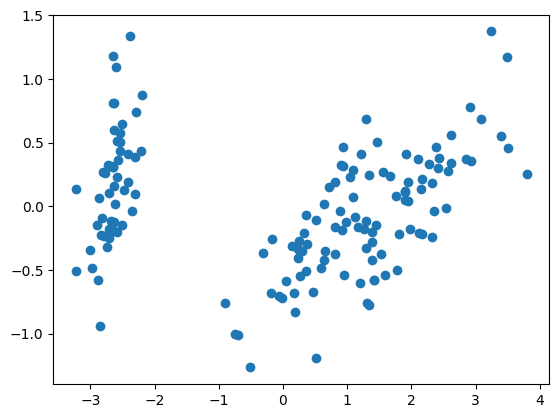

In [21]:
iris = np.load("datasets/iris.npy")
iris.shape

# for data visualisation
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
iris_2d = pca.fit_transform(iris)
plt.scatter(iris_2d[:,0], iris_2d[:,1])
plt.show()

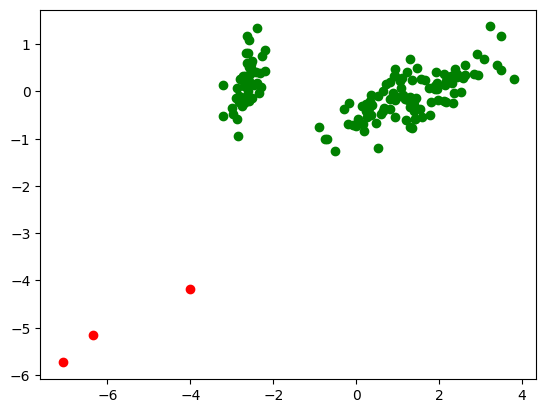

In [23]:
p = PrivacyBudget(epsilon=1, method="uniform", total_iter=2)
centers = np.array(dplloyd(k=3, X=iris, n_iter=2, priv=p, seed=13134, return_steps=False))

centers_2d = pca.transform(centers)

fig = plt.figure()
ax = plt.axes()
ax.scatter(iris_2d[:,0], iris_2d[:,1], c='green')
ax.scatter(centers_2d[:,0], centers_2d[:,1], c="red")
plt.show()